In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.metrics import MeanAbsolutePercentageError
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, GlobalAveragePooling1D, GlobalMaxPooling1D

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, mean_absolute_error

from sklearn.utils import check_array

from tensorflow.keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import GridSearchCV

#7 : 2 : 1

In [ ]:
df = pd.read_csv('ETH-USD.csv')
df1=df.reset_index()['Close']

In [ ]:
 # 3. Scaler data
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df1).reshape(-1,1))


In [ ]:
 #4. Chia train test 7:2:1
train_size = int(0.7 * len(df))
test_size = int(0.2 * len(df))
val_size = len(df1) - train_size - test_size

train_data = df1[:train_size]
test_data = df1[train_size:train_size+test_size]
val_data = df1[train_size+test_size:]

In [ ]:
    # 5. Hàm Create Dataset
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step):

		dataX.append(dataset[i:i+time_step])
		dataY.append(dataset[i + time_step])
	return np.array(dataX), np.array(dataY)
#6 Tạo input dataset cho train, val, test

time_step = 10

X_train, y_train = create_dataset(train_data, time_step)
X_val, yval = create_dataset(val_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [ ]:
# 7. Reshape input to be [samples, time steps, features] which is required for FCN
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)
X_val = X_val.reshape(X_val.shape[0],X_val.shape[1] , 1)

In [ ]:
# define FCN model
def fcn():
    model = Sequential()
    model.add(Conv1D(filters=32, kernel_size=3, activation='relu', input_shape=(10, 1)))
    model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
    model.add(GlobalMaxPooling1D())
    model.add(Dense(64, activation='relu'))
    model.add(Dense(1))
    return model

In [ ]:
model= fcn()
model.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_2 (Conv1D)           (None, 8, 32)             128       
                                                                 
 conv1d_3 (Conv1D)           (None, 6, 64)             6208      
                                                                 
 global_max_pooling1d_1 (Glo  (None, 64)               0         
 balMaxPooling1D)                                                
                                                                 
 dense_2 (Dense)             (None, 64)                4160      
                                                                 
 dense_3 (Dense)             (None, 1)                 65        
                                                                 
Total params: 10,561
Trainable params: 10,561
Non-trainable params: 0
__________________________________________________

In [ ]:
model.compile(optimizer='adam', loss='mean_squared_error')
history = model.fit(X_train, y_train, validation_data=(X_test, ytest), epochs=100, batch_size=32)

Epoch 1/100
40/40 [==============================] - 1s 10ms/step - loss: 0.0163 - val_loss: 0.0021
Epoch 2/100
40/40 [==============================] - 0s 6ms/step - loss: 0.0012 - val_loss: 0.0020
Epoch 3/100
40/40 [==============================] - 0s 5ms/step - loss: 0.0010 - val_loss: 0.0025
Epoch 4/100
40/40 [==============================] - 0s 5ms/step - loss: 9.9869e-04 - val_loss: 0.0027
Epoch 5/100
40/40 [==============================] - 0s 6ms/step - loss: 0.0010 - val_loss: 0.0019
Epoch 6/100
40/40 [==============================] - 0s 5ms/step - loss: 0.0012 - val_loss: 0.0034
Epoch 7/100
40/40 [==============================] - 0s 5ms/step - loss: 0.0011 - val_loss: 0.0018
Epoch 8/100
40/40 [==============================] - 0s 6ms/step - loss: 0.0011 - val_loss: 0.0018
Epoch 9/100
40/40 [==============================] - 0s 4ms/step - loss: 9.7536e-04 - val_loss: 0.0020
Epoch 10/100
40/40 [==============================] - 0s 4ms/step - loss: 9.8420e-04 - val_loss: 0.0

In [ ]:
# 10. Dự báo dữ liệu test, val
train_predict=model.predict(X_train)
y_pred=model.predict(X_test)
y_pred_val=model.predict(X_val)

6/6 [==============================] - 0s 2ms/step


In [ ]:
# 11. Chuẩn hóa dữ liệu y_pred, y_pred_val
train_predict=scaler.inverse_transform(train_predict)
y_pred=scaler.inverse_transform(y_pred)
y_pred_val=scaler.inverse_transform(y_pred_val)

In [ ]:
#đánh giá mô hình
def evaluation_model(model):
  # evaluate trên tập test
    loss_test = model.evaluate(X_test, ytest, verbose=0)
    print("loss_test: ", loss_test)

  # evaluate trên tập val
    loss_val = model.evaluate(X_val, yval, verbose=0)
    print("loss_val: ", loss_val)

In [ ]:

# 12. Đánh giá độ chính xác thuật toán bằng MAE,RMSE, MAPE
test_mae = mean_absolute_error(y_pred, ytest)
test_rmse = np.sqrt(np.mean((y_pred - ytest)**2))
test_mape = mean_absolute_percentage_error(y_pred, ytest)
print('Testing MAE:', test_mae)
print('Testing RMSE:', test_rmse)
print('Testing MAPE:', test_mape)
print('---------------------------')
val_mae = mean_absolute_error(y_pred_val, yval)
val_rmse = np.sqrt(np.mean((y_pred_val - yval)**2))
val_mape = mean_absolute_percentage_error(y_pred_val, yval)
print('Validation MAE:', val_mae)
print('Validation RMSE:', val_rmse)
print('Validation MAPE:', val_mape)



Testing MAE: 1980.5802556873234
Testing RMSE: 2122.4376510951015
Testing MAPE: 0.999793264965566
---------------------------
Validation MAE: 1639.3015768699654
Validation RMSE: 1650.428526394421
Validation MAPE: 0.9997906897864787


In [ ]:
evaluation_model(model)

loss_test:  0.0008570574573241174
loss_val:  0.000338588171871379


In [ ]:
# 13. Dự báo 30 ngày tiếp theo
x_input = val_data[30:].reshape(1,-1)
x_input.shape

temp_input=list(x_input)
temp_input=temp_input[0].tolist()

from numpy import array

lst_output=[]
n_steps=10
i=0
while(i<30):

    if(len(temp_input)>10):
        #print(temp_input)
        x_input=np.array(temp_input[-10:])
        print("{} day input {}".format(i,x_input))
        #x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))

        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1


0 day input [0.35304251 0.35073982 0.3500014  0.33127838 0.33445122 0.34527005
 0.34749843 0.3460968  0.34970989 0.34793483]
0 day output [[0.3253769]]
1 day input [0.35073982 0.3500014  0.33127838 0.33445122 0.34527005 0.34749843
 0.3460968  0.34970989 0.34793483 0.3253769 ]
1 day output [[0.3282463]]
2 day input [0.3500014  0.33127838 0.33445122 0.34527005 0.34749843 0.3460968
 0.34970989 0.34793483 0.3253769  0.3282463 ]
2 day output [[0.321645]]
3 day input [0.33127838 0.33445122 0.34527005 0.34749843 0.3460968  0.34970989
 0.34793483 0.3253769  0.3282463  0.32164499]
3 day output [[0.31270966]]
4 day input [0.33445122 0.34527005 0.34749843 0.3460968  0.34970989 0.34793483
 0.3253769  0.3282463  0.32164499 0.31270966]
4 day output [[0.3110608]]
5 day input [0.34527005 0.34749843 0.3460968  0.34970989 0.34793483 0.3253769
 0.3282463  0.32164499 0.31270966 0.31106079]
5 day output [[0.31097013]]
6 day input [0.34749843 0.3460968  0.34970989 0.34793483 0.3253769  0.3282463
 0.32164499

In [ ]:
#đưa giá trị về đơn vị ban đầu trước khi đc chuẩn hóa
y_future = scaler.inverse_transform(lst_output)
y_future

array([[1622.61839618],
       [1636.18427326],
       [1604.97476701],
       [1562.73048966],
       [1554.93498192],
       [1554.50636777],
       [1503.61414496],
       [1487.39486173],
       [1480.32892796],
       [1463.84658667],
       [1444.11244205],
       [1437.86865275],
       [1406.39594755],
       [1383.09635887],
       [1372.37846917],
       [1364.67370025],
       [1339.92440384],
       [1329.7505244 ],
       [1311.88272524],
       [1291.64867169],
       [1280.47835595],
       [1274.30529786],
       [1254.54959572],
       [1237.1047043 ],
       [1222.90999589],
       [1207.73681577],
       [1194.68162638],
       [1187.96075376],
       [1174.8074988 ],
       [1155.38551547]])

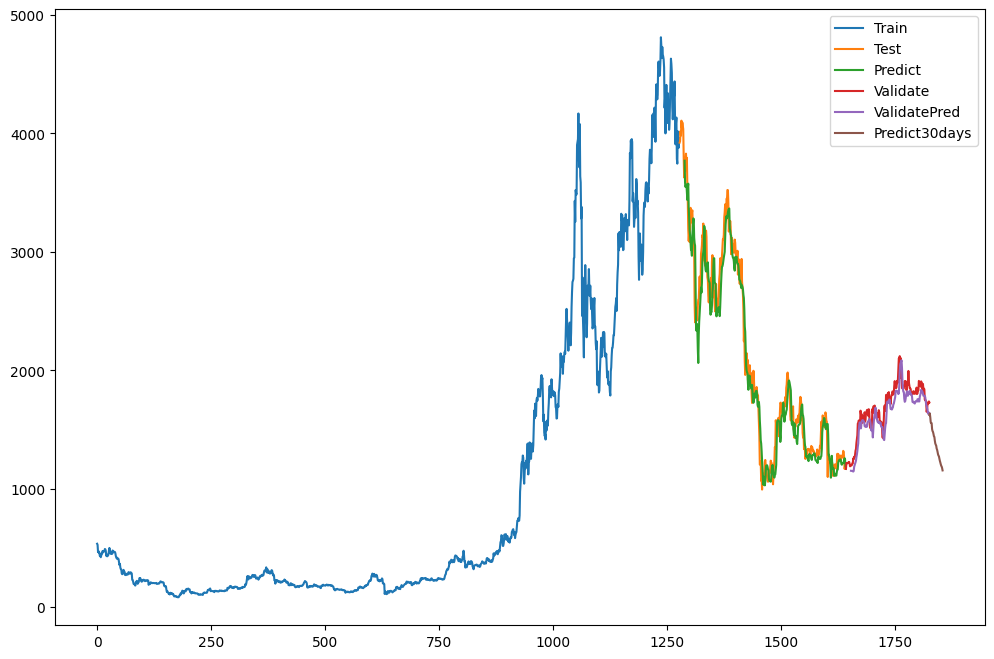

In [ ]:
# 14.Vẽ hình
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 8))

train_data_index = pd.RangeIndex(start=0, stop=train_size, step=1)
plt.plot(scaler.inverse_transform(train_data))

test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
plt.plot(test_data_index,scaler.inverse_transform(test_data))
test_data_index = pd.RangeIndex(start=train_size+11, stop=train_size+test_size, step=1)
plt.plot(test_data_index,(y_pred[:-1]))

val_data_index = pd.RangeIndex(start=train_size+test_size, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,scaler.inverse_transform(val_data))
val_data_index = pd.RangeIndex(start=train_size+test_size+11, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,y_pred_val[:-1])

prediect_data_index = pd.RangeIndex(start=len(df1)-1, stop=len(df1)+29, step=1)
plt.plot(prediect_data_index,scaler.inverse_transform(lst_output))
plt.legend(['Train','Test','Predict','Validate','ValidatePred','Predict30days'])
plt.show()

#6 : 2 : 2

In [ ]:
df = pd.read_csv('ETH-USD.csv')
df1=df.reset_index()['Close']

In [ ]:
 # 3. Scaler data
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df1).reshape(-1,1))


In [ ]:
#4. Chia train test 6:2:2
train_size = int(0.6 * len(df))
test_size = int(0.2 * len(df))
val_size = len(df1) - train_size - test_size

train_data = df1[:train_size]
test_data = df1[train_size:train_size+test_size]
val_data = df1[train_size+test_size:]

In [ ]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step):

		dataX.append(dataset[i:i+time_step])
		dataY.append(dataset[i + time_step])
	return np.array(dataX), np.array(dataY)
#6 Tạo input dataset cho train, val, test

time_step = 10

X_train, y_train = create_dataset(train_data, time_step)
X_val, yval = create_dataset(val_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [ ]:
# 7. Reshape input to be [samples, time steps, features] which is required for LFCN
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)
X_val = X_val.reshape(X_val.shape[0],X_val.shape[1] , 1)

In [ ]:
# define FCN model
def fcn():
    model = Sequential()
    model.add(Conv1D(filters=32, kernel_size=3, activation='relu', input_shape=(10, 1)))
    model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
    model.add(GlobalMaxPooling1D())
    model.add(Dense(64, activation='relu'))
    model.add(Dense(1))
    return model

In [ ]:
model= fcn()
model.summary()


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_4 (Conv1D)           (None, 8, 32)             128       
                                                                 
 conv1d_5 (Conv1D)           (None, 6, 64)             6208      
                                                                 
 global_max_pooling1d_2 (Glo  (None, 64)               0         
 balMaxPooling1D)                                                
                                                                 
 dense_4 (Dense)             (None, 64)                4160      
                                                                 
 dense_5 (Dense)             (None, 1)                 65        
                                                                 
Total params: 10,561
Trainable params: 10,561
Non-trainable params: 0
__________________________________________________

In [ ]:
model.compile(optimizer='adam', loss='mean_squared_error')
history = model.fit(X_train, y_train, validation_data=(X_test, ytest), epochs=100, batch_size=32)

Epoch 1/100
34/34 [==============================] - 2s 10ms/step - loss: 0.0108 - val_loss: 0.0032
Epoch 2/100
34/34 [==============================] - 0s 5ms/step - loss: 8.6570e-04 - val_loss: 0.0039
Epoch 3/100
34/34 [==============================] - 0s 5ms/step - loss: 6.6891e-04 - val_loss: 0.0038
Epoch 4/100
34/34 [==============================] - 0s 5ms/step - loss: 6.6181e-04 - val_loss: 0.0036
Epoch 5/100
34/34 [==============================] - 0s 5ms/step - loss: 6.5651e-04 - val_loss: 0.0047
Epoch 6/100
34/34 [==============================] - 0s 5ms/step - loss: 6.1846e-04 - val_loss: 0.0036
Epoch 7/100
34/34 [==============================] - 0s 6ms/step - loss: 6.1813e-04 - val_loss: 0.0037
Epoch 8/100
34/34 [==============================] - 0s 5ms/step - loss: 5.9526e-04 - val_loss: 0.0062
Epoch 9/100
34/34 [==============================] - 0s 5ms/step - loss: 5.5326e-04 - val_loss: 0.0031
Epoch 10/100
34/34 [==============================] - 0s 7ms/step - loss: 5.

In [ ]:
# 10. Dự báo dữ liệu test, val
train_predict=model.predict(X_train)
y_pred=model.predict(X_test)
y_pred_val=model.predict(X_val)

12/12 [==============================] - 0s 2ms/step


In [ ]:
# 11. Chuẩn hóa dữ liệu y_pred, y_pred_val
train_predict=scaler.inverse_transform(train_predict)
y_pred=scaler.inverse_transform(y_pred)
y_pred_val=scaler.inverse_transform(y_pred_val)

In [ ]:
#đánh giá mô hình
def evaluation_model(model):
  # evaluate trên tập test
    loss_test = model.evaluate(X_test, ytest, verbose=0)
    print("loss_test: ", loss_test)

  # evaluate trên tập val
    loss_val = model.evaluate(X_val, yval, verbose=0)
    print("loss_val: ", loss_val)

In [ ]:

# 12. Đánh giá độ chính xác thuật toán bằng MAE,RMSE, MAPE
test_mae = mean_absolute_error(y_pred, ytest)
test_rmse = np.sqrt(np.mean((y_pred - ytest)**2))
test_mape = mean_absolute_percentage_error(y_pred, ytest)
print('Testing MAE:', test_mae)
print('Testing RMSE:', test_rmse)
print('Testing MAPE:', test_mape)
print('---------------------------')
val_mae = mean_absolute_error(y_pred_val, yval)
val_rmse = np.sqrt(np.mean((y_pred_val - yval)**2))
val_mape = mean_absolute_percentage_error(y_pred_val, yval)
print('Validation MAE:', val_mae)
print('Validation RMSE:', val_rmse)
print('Validation MAPE:', val_mape)

Testing MAE: 2848.8998900288734
Testing RMSE: 2919.7014401591823
Testing MAPE: 0.9997795815583631
---------------------------
Validation MAE: 1504.6794576225213
Validation RMSE: 1522.4768785690737
Validation MAPE: 0.9997937116292253


In [ ]:
evaluation_model(model)

loss_test:  0.005120361223816872
loss_val:  0.0003581681230571121


In [ ]:
# 13. Dự báo 30 ngày tiếp theo
x_input = val_data[30:].reshape(1,-1)
x_input.shape

temp_input=list(x_input)
temp_input=temp_input[0].tolist()

from numpy import array

lst_output=[]
n_steps=10
i=0
while(i<30):

    if(len(temp_input)>10):
        #print(temp_input)
        x_input=np.array(temp_input[-10:])
        print("{} day input {}".format(i,x_input))
        #x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))

        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1


0 day input [0.35304251 0.35073982 0.3500014  0.33127838 0.33445122 0.34527005
 0.34749843 0.3460968  0.34970989 0.34793483]
0 day output [[0.32986197]]
1 day input [0.35073982 0.3500014  0.33127838 0.33445122 0.34527005 0.34749843
 0.3460968  0.34970989 0.34793483 0.32986197]
1 day output [[0.32794]]
2 day input [0.3500014  0.33127838 0.33445122 0.34527005 0.34749843 0.3460968
 0.34970989 0.34793483 0.32986197 0.32793999]
2 day output [[0.32467085]]
3 day input [0.33127838 0.33445122 0.34527005 0.34749843 0.3460968  0.34970989
 0.34793483 0.32986197 0.32793999 0.32467085]
3 day output [[0.32102528]]
4 day input [0.33445122 0.34527005 0.34749843 0.3460968  0.34970989 0.34793483
 0.32986197 0.32793999 0.32467085 0.32102528]
4 day output [[0.31907567]]
5 day input [0.34527005 0.34749843 0.3460968  0.34970989 0.34793483 0.32986197
 0.32793999 0.32467085 0.32102528 0.31907567]
5 day output [[0.3165194]]
6 day input [0.34749843 0.3460968  0.34970989 0.34793483 0.32986197 0.32793999
 0.32467

In [ ]:
#đưa giá trị về đơn vị ban đầu trước khi đc chuẩn hóa
y_future = scaler.inverse_transform(lst_output)
y_future

array([[1643.82281975],
       [1634.73611542],
       [1619.28036278],
       [1602.04491742],
       [1592.82759991],
       [1580.74214649],
       [1545.65890961],
       [1531.96213754],
       [1522.52304533],
       [1508.42442989],
       [1487.17815938],
       [1475.07340282],
       [1453.80162963],
       [1438.53214519],
       [1429.0900941 ],
       [1418.20453483],
       [1400.60641598],
       [1386.48849741],
       [1370.77081389],
       [1355.98066716],
       [1346.0320849 ],
       [1337.24535411],
       [1324.5734799 ],
       [1311.00140327],
       [1297.95347016],
       [1284.50637076],
       [1273.26433754],
       [1264.84443678],
       [1254.6156068 ],
       [1243.00040312]])

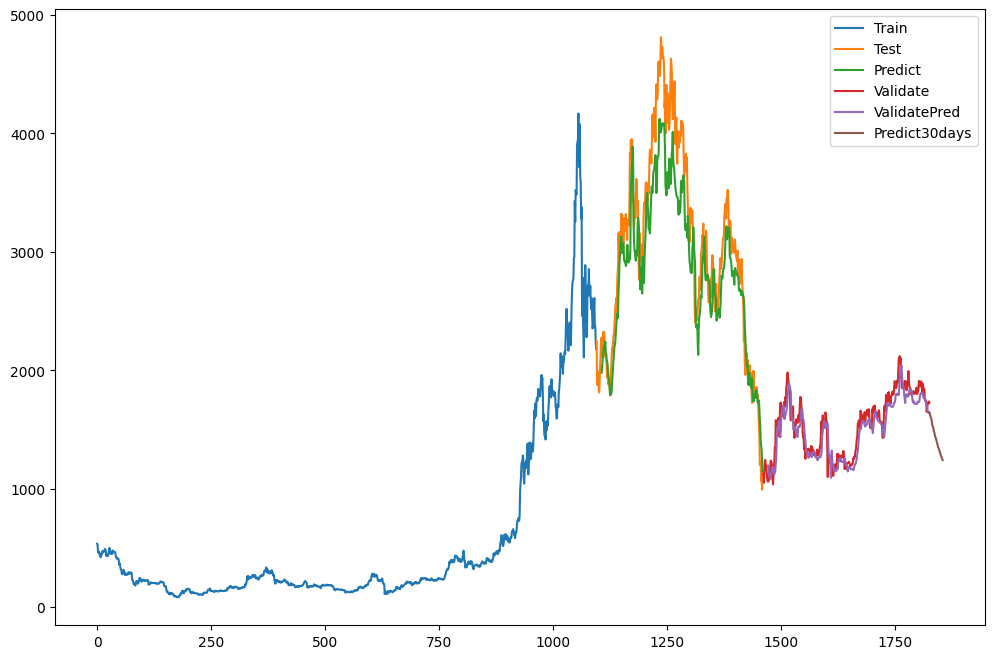

In [ ]:
# 14.Vẽ hình
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 8))

train_data_index = pd.RangeIndex(start=0, stop=train_size, step=1)
plt.plot(scaler.inverse_transform(train_data))

test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
plt.plot(test_data_index,scaler.inverse_transform(test_data))
test_data_index = pd.RangeIndex(start=train_size+11, stop=train_size+test_size, step=1)
plt.plot(test_data_index,(y_pred[:-1]))

val_data_index = pd.RangeIndex(start=train_size+test_size, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,scaler.inverse_transform(val_data))
val_data_index = pd.RangeIndex(start=train_size+test_size+11, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,y_pred_val[:-1])

prediect_data_index = pd.RangeIndex(start=len(df1)-1, stop=len(df1)+29, step=1)
plt.plot(prediect_data_index,scaler.inverse_transform(lst_output))
plt.legend(['Train','Test','Predict','Validate','ValidatePred','Predict30days'])
plt.show()

#5 : 3 : 2

In [ ]:
df = pd.read_csv('ETH-USD.csv')
df1=df.reset_index()['Close']

In [ ]:
 # 3. Scaler data
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df1).reshape(-1,1))

In [ ]:
#4. Chia train test 5 : 3 : 2
train_size = int(0.5 * len(df))
test_size = int(0.3 * len(df))
val_size = len(df1) - train_size - test_size

train_data = df1[:train_size]
test_data = df1[train_size:train_size+test_size]
val_data = df1[train_size+test_size:]

In [ ]:
    # 5. Hàm Create Dataset
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step):

		dataX.append(dataset[i:i+time_step])
		dataY.append(dataset[i + time_step])
	return np.array(dataX), np.array(dataY)
#6 Tạo input dataset cho train, val, test

time_step = 10

X_train, y_train = create_dataset(train_data, time_step)
X_val, yval = create_dataset(val_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [ ]:
# 7. Reshape input to be [samples, time steps, features] which is required for FCN
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)
X_val = X_val.reshape(X_val.shape[0],X_val.shape[1] , 1)

In [ ]:
# define FCN model
def fcn():
    model = Sequential()
    model.add(Conv1D(filters=32, kernel_size=3, activation='relu', input_shape=(10, 1)))
    model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
    model.add(GlobalMaxPooling1D())
    model.add(Dense(64, activation='relu'))
    model.add(Dense(1))
    return model

In [ ]:
model= fcn()
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_6 (Conv1D)           (None, 8, 32)             128       
                                                                 
 conv1d_7 (Conv1D)           (None, 6, 64)             6208      
                                                                 
 global_max_pooling1d_3 (Glo  (None, 64)               0         
 balMaxPooling1D)                                                
                                                                 
 dense_6 (Dense)             (None, 64)                4160      
                                                                 
 dense_7 (Dense)             (None, 1)                 65        
                                                                 
Total params: 10,561
Trainable params: 10,561
Non-trainable params: 0
__________________________________________________

In [ ]:
model.compile(optimizer='adam', loss='mean_squared_error')
history = model.fit(X_train, y_train, validation_data=(X_test, ytest), epochs=100, batch_size=32)

Epoch 1/100
29/29 [==============================] - 1s 13ms/step - loss: 2.5991e-04 - val_loss: 0.0105
Epoch 2/100
29/29 [==============================] - 0s 7ms/step - loss: 3.3741e-05 - val_loss: 0.0116
Epoch 3/100
29/29 [==============================] - 0s 7ms/step - loss: 3.2071e-05 - val_loss: 0.0084
Epoch 4/100
29/29 [==============================] - 0s 7ms/step - loss: 2.9792e-05 - val_loss: 0.0081
Epoch 5/100
29/29 [==============================] - 0s 6ms/step - loss: 3.1037e-05 - val_loss: 0.0095
Epoch 6/100
29/29 [==============================] - 0s 6ms/step - loss: 3.0131e-05 - val_loss: 0.0076
Epoch 7/100
29/29 [==============================] - 0s 6ms/step - loss: 3.3180e-05 - val_loss: 0.0083
Epoch 8/100
29/29 [==============================] - 0s 7ms/step - loss: 3.0000e-05 - val_loss: 0.0089
Epoch 9/100
29/29 [==============================] - 0s 8ms/step - loss: 3.0900e-05 - val_loss: 0.0091
Epoch 10/100
29/29 [==============================] - 0s 7ms/step - loss

In [ ]:
# 10. Dự báo dữ liệu test, val
train_predict=model.predict(X_train)
y_pred=model.predict(X_test)
y_pred_val=model.predict(X_val)

12/12 [==============================] - 0s 2ms/step


In [ ]:
# 11. Chuẩn hóa dữ liệu y_pred, y_pred_val
train_predict=scaler.inverse_transform(train_predict)
y_pred=scaler.inverse_transform(y_pred)
y_pred_val=scaler.inverse_transform(y_pred_val)

In [ ]:
#đánh giá mô hình
def evaluation_model(model):
  # evaluate trên tập test
    loss_test = model.evaluate(X_test, ytest, verbose=0)
    print("loss_test: ", loss_test)

  # evaluate trên tập val
    loss_val = model.evaluate(X_val, yval, verbose=0)
    print("loss_val: ", loss_val)

In [ ]:

# 12. Đánh giá độ chính xác thuật toán bằng MAE,RMSE, MAPE
test_mae = mean_absolute_error(y_pred, ytest)
test_rmse = np.sqrt(np.mean((y_pred - ytest)**2))
test_mape = mean_absolute_percentage_error(y_pred, ytest)
print('Testing MAE:', test_mae)
print('Testing RMSE:', test_rmse)
print('Testing MAPE:', test_mape)
print('---------------------------')
val_mae = mean_absolute_error(y_pred_val, yval)
val_rmse = np.sqrt(np.mean((y_pred_val - yval)**2))
val_mape = mean_absolute_percentage_error(y_pred_val, yval)
print('Validation MAE:', val_mae)
print('Validation RMSE:', val_rmse)
print('Validation MAPE:', val_mape)



Testing MAE: 2149.7953776129707
Testing RMSE: 2244.1811075870573
Testing MAPE: 0.9997432403797825
---------------------------
Validation MAE: 1292.1938732349026
Validation RMSE: 1304.3544365531939
Validation MAPE: 0.9997602958834554


In [ ]:
evaluation_model(model)

loss_test:  0.019850855693221092
loss_val:  0.003526414278894663


In [ ]:
# 13. Dự báo 30 ngày tiếp theo
x_input = val_data[30:].reshape(1,-1)
x_input.shape

temp_input=list(x_input)
temp_input=temp_input[0].tolist()

from numpy import array

lst_output=[]
n_steps=10
i=0
while(i<30):

    if(len(temp_input)>10):
        #print(temp_input)
        x_input=np.array(temp_input[-10:])
        print("{} day input {}".format(i,x_input))
        #x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))

        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1


0 day input [0.35304251 0.35073982 0.3500014  0.33127838 0.33445122 0.34527005
 0.34749843 0.3460968  0.34970989 0.34793483]
0 day output [[0.27604416]]
1 day input [0.35073982 0.3500014  0.33127838 0.33445122 0.34527005 0.34749843
 0.3460968  0.34970989 0.34793483 0.27604416]
1 day output [[0.25128606]]
2 day input [0.3500014  0.33127838 0.33445122 0.34527005 0.34749843 0.3460968
 0.34970989 0.34793483 0.27604416 0.25128606]
2 day output [[0.2501494]]
3 day input [0.33127838 0.33445122 0.34527005 0.34749843 0.3460968  0.34970989
 0.34793483 0.27604416 0.25128606 0.2501494 ]
3 day output [[0.2491073]]
4 day input [0.33445122 0.34527005 0.34749843 0.3460968  0.34970989 0.34793483
 0.27604416 0.25128606 0.2501494  0.2491073 ]
4 day output [[0.2483951]]
5 day input [0.34527005 0.34749843 0.3460968  0.34970989 0.34793483 0.27604416
 0.25128606 0.2501494  0.2491073  0.2483951 ]
5 day output [[0.24733153]]
6 day input [0.34749843 0.3460968  0.34970989 0.34793483 0.27604416 0.25128606
 0.2501

In [ ]:
#đưa giá trị về đơn vị ban đầu trước khi đc chuẩn hóa
y_future = scaler.inverse_transform(lst_output)
y_future

array([[1389.38410858],
       [1272.33327829],
       [1266.95939817],
       [1262.03258993],
       [1258.66546093],
       [1253.63713511],
       [1049.47907553],
       [1016.66571827],
       [1056.76199345],
       [1028.28909409],
       [ 991.43391393],
       [ 976.70512863],
       [ 862.37315197],
       [ 875.42362126],
       [ 899.16837969],
       [ 870.70696357],
       [ 829.5205544 ],
       [ 815.55875169],
       [ 768.5175748 ],
       [ 794.50114467],
       [ 789.91333894],
       [ 768.35131422],
       [ 733.07293251],
       [ 733.46406757],
       [ 718.67835915],
       [ 725.38824166],
       [ 712.26697073],
       [ 690.49944512],
       [ 667.69074785],
       [ 676.79682576]])

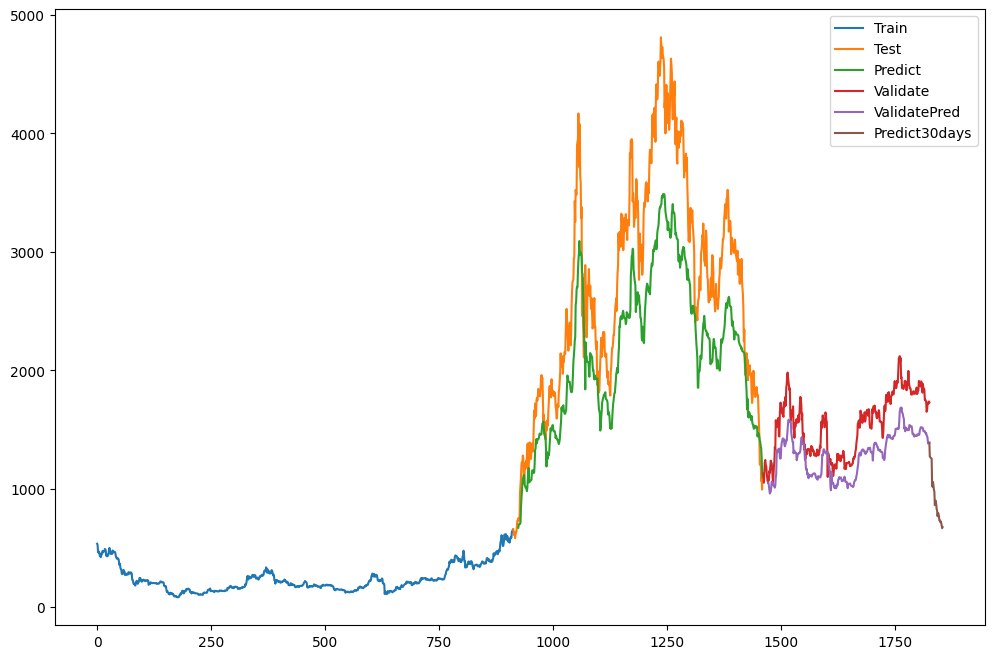

In [ ]:
# 14.Vẽ hình
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 8))

train_data_index = pd.RangeIndex(start=0, stop=train_size, step=1)
plt.plot(scaler.inverse_transform(train_data))

test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
plt.plot(test_data_index,scaler.inverse_transform(test_data))
test_data_index = pd.RangeIndex(start=train_size+11, stop=train_size+test_size, step=1)
plt.plot(test_data_index,(y_pred[:-1]))

val_data_index = pd.RangeIndex(start=train_size+test_size, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,scaler.inverse_transform(val_data))
val_data_index = pd.RangeIndex(start=train_size+test_size+11, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,y_pred_val[:-1])

prediect_data_index = pd.RangeIndex(start=len(df1)-1, stop=len(df1)+29, step=1)
plt.plot(prediect_data_index,scaler.inverse_transform(lst_output))
plt.legend(['Train','Test','Predict','Validate','ValidatePred','Predict30days'])
plt.show()